<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/coo_to_midpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import linspace, min, max, sqrt, ravel
from pandas import DataFrame, read_csv, concat
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from gc import collect
from io import BytesIO
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from google.colab import files
uploaded = files.upload()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Saving assumed_pha_thousand.csv to assumed_pha_thousand.csv


In [ ]:
df = read_csv(BytesIO(uploaded['assumed_pha_thousand.csv']))
df.fillna(df.median(axis=0), # Fills median values in row
          inplace=True,)
df.head()

,X1,Y1,X2,Y2,MID_POINT_X,MID_POINT_Y,Area,long,lat,Long_minus,Lat_minus
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323,86,323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506,899,506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605,841,605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584,933,584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442,1013,442


In [ ]:
print(df.columns)

Index(['X1', 'Y1', 'X2', 'Y2', 'MID_POINT_X', 'MID_POINT_Y', 'Area', 'long',
       'lat', 'Long_minus', 'Lat_minus'],
      dtype='object')


In [ ]:
df.rename(columns={'MID_POINT_X': 'MPX',
                   'MID_POINT_Y': 'MPY',
                   'Long_minus': 'Long_m',
                   'Lat_minus': 'Lat_m',},
          inplace=True,)
df.head()

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat,Long_m,Lat_m
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323,86,323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506,899,506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605,841,605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584,933,584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442,1013,442


In [ ]:
df.tail()

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat,Long_m,Lat_m
13,1097,236,1117,274,1107.0,255.0,760,24.921000,67.143724,1000,724
14,870,274,897,343,883.5,308.5,1863,24.920927,67.143555,927,555
15,215,409,264,535,239.5,472.0,6174,24.920873,67.143292,873,292
16,270,548,342,689,306.0,618.5,10152,24.920829,67.143271,829,271
17,358,536,429,682,393.5,609.0,10366,24.920827,67.143284,827,284


In [ ]:
df1, df2 = df.head(), df.tail()
conc_data_row = concat([df1,
                        df2,],
                        axis=0, # Adds dataframes in row
                        ignore_index=False,)
conc_data_row

,X1,Y1,X2,Y2,MPX,MPY,Area,long,lat,Long_m,Lat_m
0,297,395,343,519,320.0,457.0,5704,24.920860,67.143323,86,323
1,839,315,870,404,854.5,359.5,2759,24.920899,67.143506,899,506
2,1223,284,1256,361,1239.5,322.5,2541,24.920841,67.143605,841,605
3,871,270,896,334,883.5,302.0,1600,24.920933,67.143584,933,584
4,421,294,450,367,435.5,330.5,2117,24.921013,67.143442,1013,442
13,1097,236,1117,274,1107.0,255.0,760,24.921000,67.143724,1000,724
14,870,274,897,343,883.5,308.5,1863,24.920927,67.143555,927,555
15,215,409,264,535,239.5,472.0,6174,24.920873,67.143292,873,292
16,270,548,342,689,306.0,618.5,10152,24.920829,67.143271,829,271
17,358,536,429,682,393.5,609.0,10366,24.920827,67.143284,827,284


In [ ]:
del conc_data_row
collect()

128

In [ ]:
del df1
collect()

0

In [ ]:
del df2
collect()

0

In [ ]:
assert df['X1'].notnull().all()
assert df['Y1'].notnull().all()
assert df['X2'].notnull().all()
assert df['Y2'].notnull().all()
assert df['MPX'].notnull().all()
assert df['MPY'].notnull().all()
assert df['Area'].notnull().all()
assert df['long'].notnull().all()
assert df['lat'].notnull().all()
assert df['Long_m'].notnull().all()
assert df['Lat_m'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


X1       NaN
Y1       NaN
X2       NaN
Y2       NaN
MPX      NaN
MPY      NaN
Area     NaN
long     NaN
lat      NaN
Long_m   NaN
Lat_m    NaN
dtype: float64

In [ ]:
df.drop_duplicates(keep='first',
                   inplace=True,)
print(df.shape)

(18, 11)


In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      18 non-null     int64  
 1   Y1      18 non-null     int64  
 2   X2      18 non-null     int64  
 3   Y2      18 non-null     int64  
 4   MPX     18 non-null     float64
 5   MPY     18 non-null     float64
 6   Area    18 non-null     int64  
 7   long    18 non-null     float64
 8   lat     18 non-null     float64
 9   Long_m  18 non-null     int64  
 10  Lat_m   18 non-null     int64  
dtypes: float64(4), int64(7)
memory usage: 1.7 KB


In [ ]:
profile = ProfileReport(df,
                        title='Coo-Midpoint Report',
                        explorative=True,
                        progress_bar=True,)
profile.to_notebook_iframe()

In [ ]:
del profile
collect()

364283

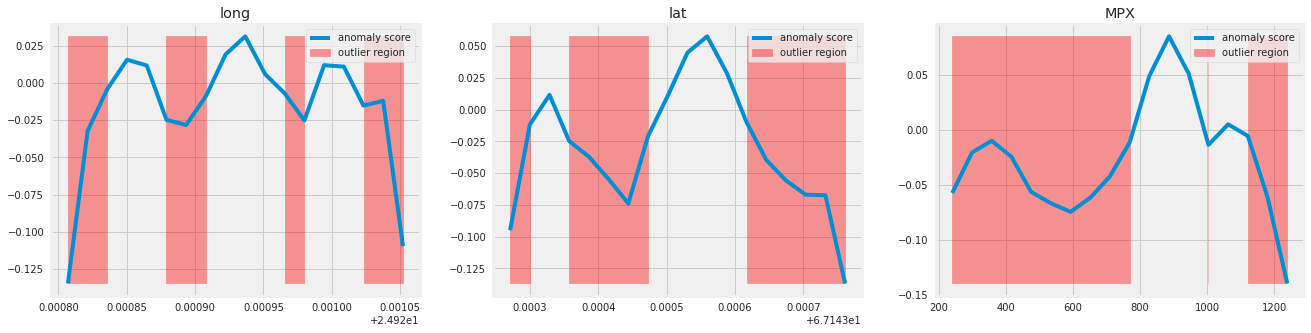

In [ ]:
cols = ['long',
        'lat',
        'MPX',]
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),
                        facecolor='w',
                        edgecolor='k',)
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = linspace(df[column].min(),
                  df[column].max(),
                  len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score),
                        max(anomaly_score), 
                        where=outlier==-1,
                        color='r', 
                        alpha=.4,
                        label='outlier region',)
    axs[i].legend()
    axs[i].set_title(column)

In [ ]:
scaler = StandardScaler()
scaler.fit(df)
scaled_df = scaler.transform(df)

In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_df)
df_pca.shape

(18, 2)

In [ ]:
pca.explained_variance_ratio_

array([0.73039592, 0.16044618])

In [ ]:
del scaled_df
collect()

15

In [ ]:
del df_pca
collect()

0

In [ ]:
any(df.long <= 0)

False

In [ ]:
any(df.lat <= 0)

False

In [ ]:
any(df.MPX <= 0)

False

In [ ]:
X = df[['long',
        'lat',]]
y = df['MPX']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 0,)

In [ ]:
X_train.head()

,long,lat
2,24.920841,67.143605
16,24.920829,67.143271
17,24.920827,67.143284
9,24.921040,67.143523
7,24.921052,67.143737


In [ ]:
regr.fit(X_train,
         y_train,)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
del X_train
collect()

11

In [ ]:
del y_train
collect()

0

In [ ]:
y_pred = regr.predict(X_test)
print(X_test)
print(y_pred)

print('Coefficients:', 
      regr.coef_,)

print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test,
                            y_pred.ravel(),))

print('Mean squared error: %.2f'
      % mean_squared_error(y_test,
                           y_pred.ravel(),))

print('Root mean square error: %.2f'
      % sqrt(mean_squared_error(y_test,
                                y_pred.ravel(),)))

print('Coefficient of determination: %.2f'
      % r2_score(y_test, 
                 y_pred.ravel(),))

         long        lat
1   24.920899  67.143506
6   24.920981  67.143761
8   24.921042  67.143622
10  24.921001  67.143343
14  24.920927  67.143555
4   24.921013  67.143442
[ 815.8652367  1276.37810554  730.32264198   90.48372321  870.18215482
  324.63655277]
Coefficients: [-2791260.87757156  2703514.74829241]
Mean absolute error: 79.65
Mean squared error: 8641.46
Root mean square error: 92.96
Coefficient of determination: 0.91


In [ ]:
model = Sequential()
model.add(Dense(1,
                input_shape=(1,),))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(Adam(lr = 0.8),
              'mean_squared_error',)

In [ ]:
model.fit(y_test,
          y_pred,
          epochs = 130,)

Epoch 1/130
6/6 [==============================] - 0s 1ms/step - loss: 7207.8228
Epoch 2/130
6/6 [==============================] - 0s 406us/step - loss: 7187.8516
Epoch 3/130
6/6 [==============================] - 0s 314us/step - loss: 7177.3022
Epoch 4/130
6/6 [==============================] - 0s 655us/step - loss: 7169.0815
Epoch 5/130
6/6 [==============================] - 0s 330us/step - loss: 7153.4644
Epoch 6/130
6/6 [==============================] - 0s 231us/step - loss: 7134.9751
Epoch 7/130
6/6 [==============================] - 0s 490us/step - loss: 7122.2183
Epoch 8/130
6/6 [==============================] - 0s 267us/step - loss: 7112.4844
Epoch 9/130
6/6 [==============================] - 0s 212us/step - loss: 7098.3081
Epoch 10/130
6/6 [==============================] - 0s 259us/step - loss: 7081.2495
Epoch 11/130
6/6 [==============================] - 0s 207us/step - loss: 7067.5098
Epoch 12/130
6/6 [==============================] - 0s 300us/step - loss: 7056.4468
Epo

In [ ]:
W , B = model.get_weights()

In [ ]:
W

array([[1.0506284]], dtype=float32)

In [ ]:
B

array([-52.765278], dtype=float32)

In [ ]:
explained_variance_score(y_test,
                         y_pred.ravel(),)

0.9263849877722251

In [ ]:
del X_test
collect()

44

In [ ]:
del y_test
collect()

0

In [ ]:
regr.predict([[24.920925,
               67.143550,]])

array([862.24710283])